In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans

In [2]:
def moments(row):
    idade = row['idade']
    renda_mensal = row['renda_mensal']
    investimento_total = row['investimento_total']
    
    if 0 <= idade < 16:
        return 'Momento 1'
    elif 16 <= idade < 26:
        return 'Momento 2'
    elif 26 <= idade < 60:
        if renda_mensal >= 5e3:
            if investimento_total < 2e5:
                return 'Momento 6'
            else:
                return 'Momento 7'
        elif (idade < 36) and (renda_mensal < 5e3):
            return 'Momento 3'
        elif (idade < 45) and (renda_mensal < 5e3):
            return 'Momento 4'
        elif renda_mensal < 5e3:
            return 'Momento 5'
    elif idade >= 60:
        if renda_mensal < 5e3:
            return 'Momento 8'
        else:
            return 'Momento 9'

In [ ]:
df = pd.read_csv(
    'ldw-base_relacionamento_atual.csv',
    delimiter=';',
    dtype={'cod_carteira': str}
    )\
    .astype(
        {
            'cod_central': str,
            'cod_coop': str,
            'num_conta_principal': str,
            'cod_ua': str,
            'num_cpf_cnpj': str,
            'cod_cnae': str,
            'ano_mes': str,
            'flg_cheque_especial': str,
            'num_ano_mes': str,
            'flg_associado': str,
            'digital_acessou_30d': int,
            'mobi_acessou_30d': int
        }
    )\
    .assign(
        cad_pix=lambda x: x.cad_pix.map({'S': 1, 'N': 0}),
        assoc_desde=lambda x: pd.to_datetime(x.assoc_desde),
        tempo_assoc=lambda x: (pd.Timestamp('2024-11-01') - x.assoc_desde).dt.days,
        ultimo_contato=lambda x: pd.to_datetime(x.ultimo_contato),
        nivel_risco=lambda x: x.nivel_risco.fillna('DEFAULT'),
        score_principalidade=lambda x: x.score_principalidade.fillna(0),
        faixa_principalidade=lambda x: x.faixa_principalidade.replace('MISSING', np.nan).fillna('BAIXA'),
        publico_estrategico=lambda x: x.publico_estrategico.fillna('cooperativa'),
        investimento_total=lambda x: x.sld_lci + x.sld_lca + x.sld_fundos + x.sld_dep_a_prazo,
        qt_investimento_media=lambda x: x.loc[:, [
            'qt_fundos', 'qt_lci', 'qt_lca',
            'qt_dep_a_prazo']].mean(axis=1),
        alavancagem=lambda x: x.sld_cred_scr_2m / x.renda_mensal,
        flg_sexo=lambda x: [
            'PJ' if x.segmento.loc[i] == "PJ"
            else x.flg_sexo.loc[i]
            for i in range(x.shape[0])
        ],
    )\
    .query('(status_associado == "ATIVO") and (renda_mensal >= 0)')\
    .drop(
        columns=[
            'sld_cred_scr_180_2m', 'sld_cred_sicredi_sas_2m',
            'sld_cred_sicredi_sas_180_2m', 'mc_seguro_agricola',
            'vlr_prej_coobrigacoes', 'vlr_prej_outros', 'sld_cred_moeda',
            'sld_seg_elementares', 'sld_seg_agricola', 'fat_ano',
            'mc_seg_elementares', 'mc_domicilio', 'mc_cred_moeda',
            'qt_cred_moeda', 'qt_seg_elementares', 'qt_seg_agricola'
        ]
    )\
    .dropna(subset=['idade'])\
    .reset_index(drop=True)
    #.query('(status_associado == "ATIVO") and (segmento != "PJ")')\

df = df\
    .astype(
        {
            col: str
            for col in df.loc[:,df.columns.str.startswith(
                ('prod', 'flg', 'digital',
                 'possui', 'ib', 'mobi', 'fone')
            )].columns
        }
    )\
    .assign(
        qt_investimento_media=lambda x: x.loc[:, [
            'qt_fundos', 'qt_lci', 'qt_lca',
            'qt_dep_a_prazo']].mean(axis=1)
    )

df.loc[(df.idade < 15) & (df.renda_mensal > 1e2), 'renda_mensal'] = 0
df.loc[
    (df.idade >= 19) &
    (df.renda_mensal <= 100) &
    (~df.desc_cbo.isin(['Estudantes'])),
    'renda_mensal'] = np.nan
df.loc[df.renda_mensal.isna(), 'renda_mensal'] = df\
    .groupby('desc_cbo')\
    .renda_mensal\
    .transform('median')

df = df\
    .assign(
        momentos=lambda x: x.apply(moments, axis=1)
    )

In [ ]:
df.query('renda_mensal.isna()')

In [22]:
knn = KNNImputer(n_neighbors=10)
knn_cols = df.dropna(subset=['renda_mensal'])\
    .select_dtypes(include=np.number).corr(method='spearman')\
    .renda_mensal.abs().sort_values(ascending=False).head(50).index\
    .tolist()
df_impute_knn = knn.fit_transform(df[knn_cols])
df_impute_knn = pd.DataFrame(
    df_impute_knn,
    columns=knn_cols
    )
df['renda_mensal'] = df_impute_knn.renda_mensal
df = df\
    .assign(
        momentos=lambda x: x.apply(moments, axis=1)
    )

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [60]:
df_cluster = df\
    .loc[:, [
        'idade', 'renda_mensal',
        'tempo_assoc', 'score_principalidade',
        'isa', 'sld_previdencia',
        'qt_investimento_media', 'alavancagem',
        'sld_inad_ca_0'
        ] +
        df.columns[df.columns.str.startswith('sld_seg')].tolist() +
        df.columns[df.columns.str.startswith('sld_cred')].tolist() +
        df.columns[df.columns.str.startswith('mc_') & ~df.columns.isin([
            'mc_assoc', 'mc_assoc_6_meses', 'mc_total'
        ])].tolist() #+
        #df.filter(like='vlr_prej').columns.tolist() +
        #df.filter(like='vlr_prov').columns.tolist()
    ]\
    .fillna(0)
df_cluster_columns = df_cluster.columns.tolist()

In [61]:
class Inertia: 
    def __init__(self, data, cluster_columns=None, set_groups=20):
        self.set_groups = set_groups + 1
        self.data = data
        self.data_cluster = data.loc[:, cluster_columns]
        self.cluster_columns = cluster_columns

    def find_groups(self, n_clusters):
        return KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            random_state=42
            ).fit(self.data_cluster)\
            .labels_
    
    def calc_inertia(self):
        return [
            KMeans(
                n_clusters=i,
                init='k-means++',
                random_state=42
            ).fit(self.data_cluster)\
            .labels_
            for i in range(1, self.set_groups)
        ]

    def plot_inertia(self):
        plt.figure(figsize=(10, 8))
        plt.plot(
            range(1, self.set_groups),
            self.calc_inertia(),
            marker='o', 
            linestyle='--'
        )

In [44]:
for seed in range(42):
    kmeans = KMeans(
        n_clusters=9,
        tol=1e-16,
        random_state=seed
        ).fit(df_cluster)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}, {seed}")

Number of elements assigned to each cluster: [158616     15      2    120     52    324      9     35      2], 0
Number of elements assigned to each cluster: [154744     24      8     62      5     40    307   3983      2], 1
Number of elements assigned to each cluster: [154760     49      8     22    309     40      2      2   3983], 2
Number of elements assigned to each cluster: [158620     15     37      2      8    118      2     49    324], 3
Number of elements assigned to each cluster: [158620    120      8     15     49      2      2    324     35], 4
Number of elements assigned to each cluster: [158616     15      9     35    120      2      2     52    324], 5
Number of elements assigned to each cluster: [158616     35      2    324     52      2     15      9    120], 6
Number of elements assigned to each cluster: [158592    302     15     27      5      2      2    188     42], 7
Number of elements assigned to each cluster: [158551     24      2     63     27      5    188  

In [62]:
kmeans = KMeans(
    n_clusters=9,
    tol=1e-16,
    random_state=18
    ).fit(df_cluster)

In [63]:
df = df.assign(
    Grupos=kmeans.labels_
    )\
    .sort_values('Grupos')\
    .astype({'Grupos': str})

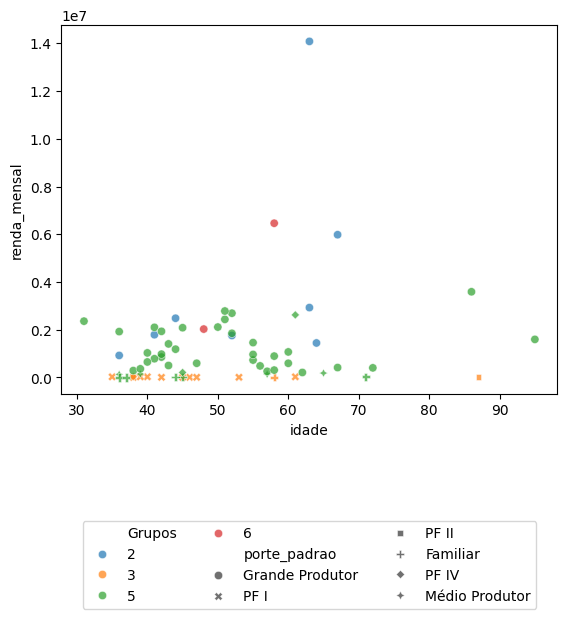

In [69]:
sns.scatterplot(
    data=df\
        .query('Grupos not in ["0", "8", "7", "4", "1"]')\
        .assign(
            #renda_mensal=lambda x: np.log1p(x.renda_mensal),
            vlr_prej_cred_comercial=lambda x: np.log1p(x.vlr_prej_cred_comercial)
        ),
    x='idade',
    y='renda_mensal',
    style='porte_padrao',
    hue='Grupos',
    alpha=.7
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

In [73]:
df.query('Grupos == "3"')

,ano_mes,ano_mes_data,cod_central,cod_coop,num_conta_principal,cod_ua,status_associado,flg_prejuizo,cod_carteira,nom_gestor_carteira,...,sld_seg_rural,qt_seg_rural,sld_seg_out_familias,qt_seg_out_familias,tempo_assoc,investimento_total,qt_investimento_media,alavancagem,momentos,Grupos
80204,202409,2024-09-01,2000,2201,126330,4,ATIVO,N,141,ISABEL CRISTINA MORAES VENTURA XAVIER,...,0.0,0,0.0,0,4687,0.00,0.00,115546193.0,Momento 6,3
113358,202409,2024-09-01,2000,2211,169960,4,ATIVO,N,126,GISELE SOUZA DA CUNHA,...,0.0,0,0.0,0,351,0.00,0.00,88574410.0,Momento 6,3
2850,202409,2024-09-01,2000,2211,58637,6,ATIVO,N,144,HALLYSON ALBERTO DE LIMA E SILVA,...,0.0,0,0.0,0,4300,0.00,0.00,99974016.0,Momento 6,3
124609,202409,2024-09-01,2000,2201,304913,3,ATIVO,N,132,JANE MARIA DA SILVA GALVAO,...,0.0,0,0.0,0,1998,27180.23,0.25,88022648.0,Momento 6,3
41163,202409,2024-09-01,2000,2201,565804,28,ATIVO,N,143,VICTOR VINICIUS LOPES LIMA VERDE,...,0.0,0,0.0,0,80,1013954.41,0.50,85962481.0,Momento 9,3
8120,202409,2024-09-01,2000,2201,577388,16,ATIVO,N,010101,KENIA MILENE CAMPOS PINTO,...,0.0,0,0.0,0,87,0.00,0.00,90400755.0,Momento 6,3
78245,202409,2024-09-01,2000,2004,523,2,ATIVO,N,113,DELVA MARIA NOGUEIRA DA SILVA,...,0.0,0,0.0,0,2930,0.00,0.00,127763249.0,Momento 9,3
74886,202409,2024-09-01,2000,2205,525751,34,ATIVO,N,010401,SERGIO RICARDO TAQUES DA SILVA,...,0.0,0,0.0,0,206,0.00,0.00,95584958.0,Momento 6,3
90124,202409,2024-09-01,2000,2102,222380,2,ATIVO,N,991,AGATHA CRISTINA CARVALHO DA SILVA SOTERO,...,0.0,0,0.0,0,4034,0.00,0.00,116745825.0,Momento 6,3
41967,202409,2024-09-01,2000,2207,59021,2,ATIVO,N,149,TAYNA VANDERLEI SOUSA LIRA,...,0.0,0,0.0,0,2823,4407.74,0.25,96047852.0,Momento 6,3


In [ ]:
stack_df = df.loc[:,
                df.columns[df.columns.str.startswith('prod_')].tolist()
                + ['Grupos']
            ]\
            .set_index('Grupos')\
            .stack()\
            .reset_index(name='contem')\
            .astype({'contem': int})\
            .rename(columns={'level_1': 'produto'})\
            .groupby(['Grupos', 'produto'])\
            .contem\
            .sum()\
            .reset_index(name='total_produto_grupo')

In [133]:
wcss = []
for i in range(1, 21):
    kmeans_pca = KMeans(
        n_clusters=i,
        init='k-means++',
        random_state=42
    )
    kmeans_pca.fit(df_cluster)
    wcss.append(kmeans_pca.inertia_)

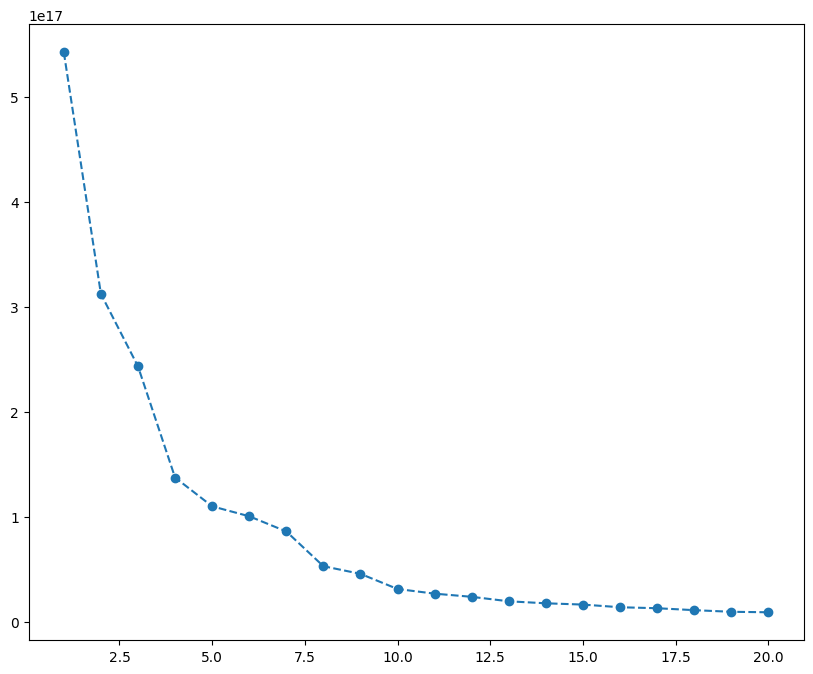

In [134]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')

In [236]:
df.to_csv('relacionamento_clusters.csv', index=False)